In [ ]:
import pandas as pd
import pickle
from helper_classes.semrush.semrush_api import SEMRushAPI

# your SEMRush API Key
api_key = ''
# SEMRush Keyword Database used (Complete list https://www.semrush.com/api-analytics/)
database = 'de'

sr = SEMRushAPI(api_key, database=database)
reg_score = []

In [ ]:
# Define Domain to optimize & competitors (more competitors=better results)
main_domain = ['www.barf-alarm.de']
competitor_domains = ['barf-factory.de', 'www.barfers-wellfood.de',
                      'www.barfinfo.de', 'www.barfkoeln.de', 'www.barfshop-koeln.de',
                      'www.barfshop.de']
base_domains = main_domain + competitor_domains

In [ ]:
# Get Information about the Domains (Quelle: SEMRUSH)
domain_arr = []
for domain in base_domains:
    sr_result = sr.get_domain_overview(domain)
    if sr_result:
        domain_arr.append(sr_result[0])

In [ ]:
domain_df = pd.DataFrame.from_records(domain_arr)

In [ ]:
domain_df

In [ ]:
# Get all Keywords for the listed Domains (Quelle: SEMRUSH API)
# This can take a while an need API Credits
# The results of the API will be cached
keyword_df = None
keyword_df = pd.DataFrame()
for domain in base_domains:
    res = sr.get_domain_keywords(domain, count=2000)
    if res:
        kw_df = pd.DataFrame.from_records(res)
        kw_df["Domain"] = domain
        keyword_df = pd.concat([kw_df, keyword_df])

In [ ]:
# Delete not needed columns
if "Position Difference" in keyword_df:
    del keyword_df["Position Difference"]
if "Previous Position" in keyword_df:
    del keyword_df["Previous Position"]
if "Trends" in keyword_df:
    del keyword_df["Trends"]
if "Traffic (%)" in keyword_df:
    del keyword_df["Traffic (%)"]
if "Traffic Cost (%)" in keyword_df:
    del keyword_df["Traffic Cost (%)"]

# Convert Strings to numbers
keyword_df["CPC"] = pd.to_numeric(keyword_df["CPC"]).astype(float)
keyword_df["Competition"] = pd.to_numeric(keyword_df["Competition"]).astype(float)
keyword_df["Search Volume"] = pd.to_numeric(keyword_df["Search Volume"]).astype(float)
keyword_df["Position"] = pd.to_numeric(keyword_df["Position"]).astype(float)
keyword_df["Number of Results"] = pd.to_numeric(keyword_df["Number of Results"]).astype(float)

In [ ]:
keyword_df.sort_values('Search Volume', ascending=False).head(10)

In [9]:
cd E:\Machine Learning for SEO

E:\Machine Learning for SEO


![](out_cell-nine.jpg)


In [8]:
from IPython.core.display import Image 

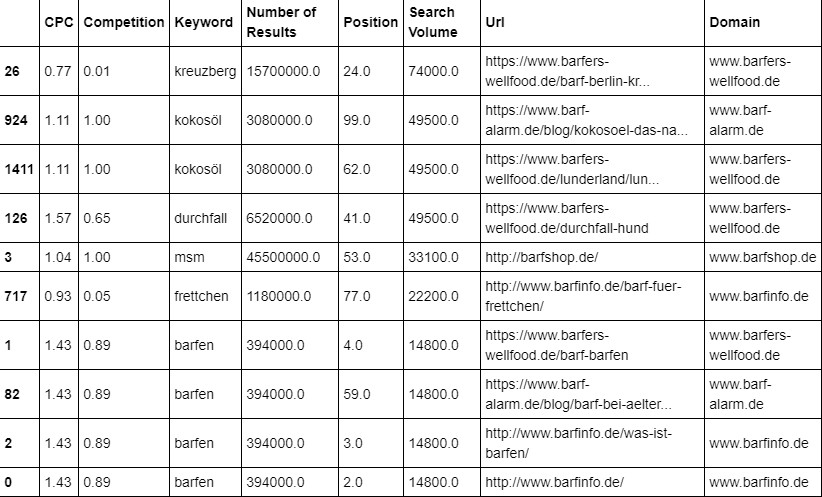

In [21]:
Image(filename="E:\Machine Learning for SEO\out_cell-nine.jpg")

In [ ]:
# Each keyword only once
keyword_df_unique = keyword_df.drop_duplicates(subset='Keyword', keep="last")

# Delete not neded rows
del keyword_df_unique["Position"]
del keyword_df_unique["Url"]
del keyword_df_unique["Domain"]

print("Count unique Keywords for all Domains: {}".format(len(keyword_df_unique.index)))
keyword_df_unique.head(10)

In [44]:
# The  result would be "Count unique Keywords for all Domains: 3674"

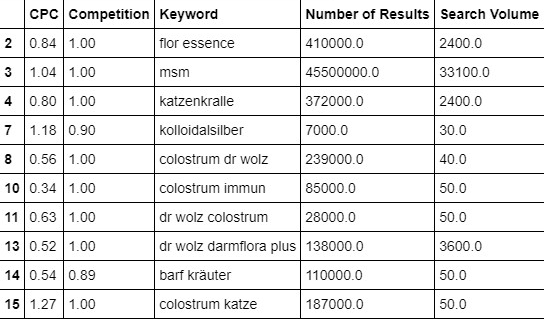

In [28]:
Image(filename="E:\Machine Learning for SEO\outputcelltwentyseven.jpg")

In [ ]:
# Get Information about the found urls of the positions
# Reduce to only competitors
all_urls = keyword_df.drop_duplicates(subset='Url', keep="last")

urls_to_crawl_df = all_urls[all_urls['Domain'].isin(base_domains)]
urls_to_crawl = urls_to_crawl_df.Url
print("Count of URLs to crawl: {}".format(len(urls_to_crawl)))

In [29]:
# The result would be "Count of URLs to crawl: 400"

Count of URLs to crawl: 400


In [ ]:
# load a simple crawler to fetch URLs
from helper_classes.simple_crawler.simple_crawler import Crawler
crawler = Crawler(30) # How much Threads in parallel?

# Crawl
# Crawl results are cached
res = crawler.get_websites(urls_to_crawl)

# Build DF from cralwed URLS
crawled_df = pd.DataFrame.from_records(res)
crawled_df.rename(columns={'url': 'Url'}, inplace=True)

In [ ]:
print("Title & Content for {} Urls".format(len(crawled_df.index)))
crawled_df.head()

In [43]:
# The result would be "Title & Content for 400 Urls"

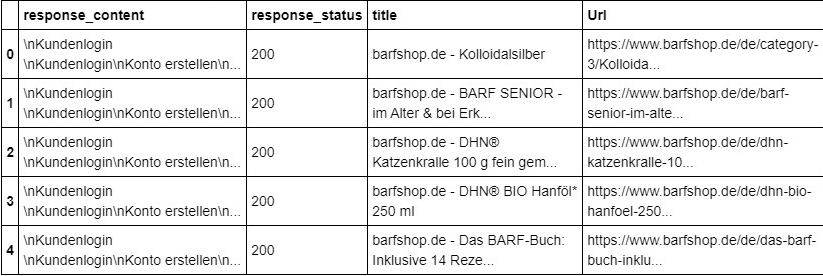

In [31]:
Image(filename="E:\Machine Learning for SEO\cellout_at_31.jpg")

In [ ]:
# Combine Keywords and positions with crawled content
combined_df = pd.merge(keyword_df, crawled_df, on='Url', how='outer')

In [ ]:
combined_df.head()

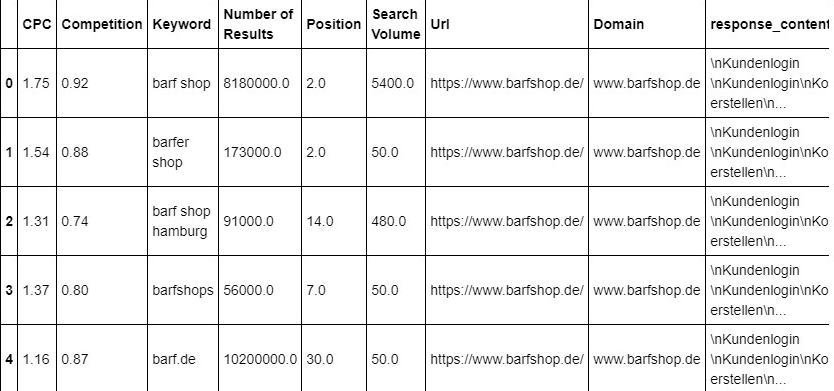

In [32]:
Image(filename="E:\Machine Learning for SEO\out_at_34_part_1.jpg")

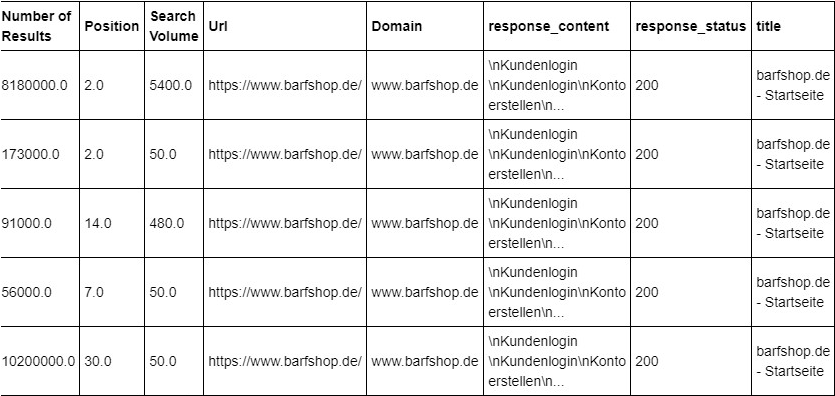

In [33]:
Image(filename="E:\Machine Learning for SEO\out_at_34_part_2.jpg")

In [ ]:
# Check each Title, URL, Content if words of Keyword phrase are in it and save information as float
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
from urllib.parse import urlparse
stopwords_list = set(stopwords.words('german'))

def check_keyword(args):
    
    words = args["Keyword"].split(" ")
    words_wo_stop = [i for i in words if not i in stopwords_list]
    count_kw = len(words_wo_stop)
    
    found_words_title = 0
    found_words_content = 0
    found_words_url = 0
    found_words_domain = 0
    url_found = 0.0
    content_found = 0.0
    title_found = 0.0
    domain_found = 0.0
    is_homepage = 0
    for word in words_wo_stop:
        if str(word) in str(args["Domain"]):
            found_words_domain += 1 

        path = urlparse(args["Url"]).path
        if str(word) in str(path):
            found_words_url += 1 
        if "/" == path:
            is_homepage = 1
        if str(word) in str(args["title"]):
            found_words_title += 1
        if str(word) in str(args["response_content"]):
            found_words_content += 1
    if found_words_url > 0:
        url_found = found_words_url / count_kw
    if found_words_title > 0:
        title_found = found_words_title / count_kw
    if found_words_content > 0:
        content_found = found_words_content / count_kw
    if found_words_content > 0:
        domain_found = found_words_domain / count_kw
    return pd.Series({'title_found': title_found, 
                      'content_found': content_found, 
                      'url_found': url_found, 
                      'domain_found': domain_found,
                      'is_homepage': is_homepage})
rated_df = combined_df.join(combined_df.apply(check_keyword, axis=1))

In [ ]:
rated_df.head()

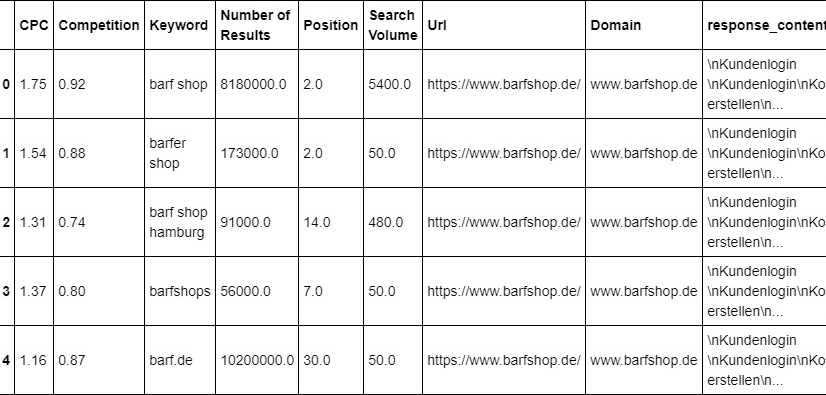

In [4]:
Image(filename="E:\Machine Learning for SEO\out_combined_rated_part_1.jpg")

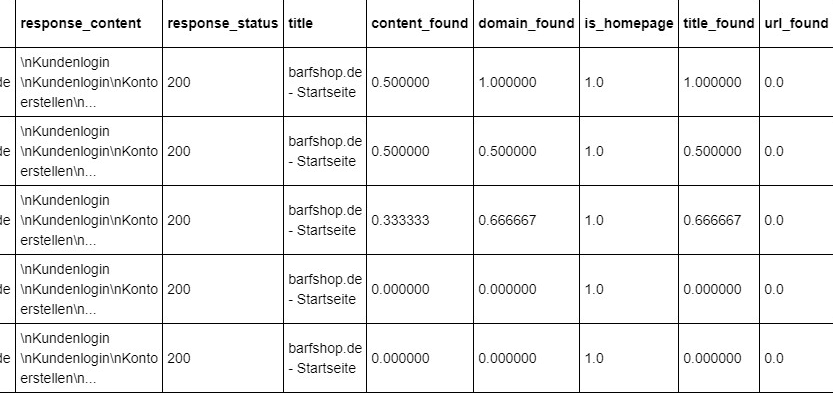

In [5]:
Image(filename="E:\Machine Learning for SEO\out_combined_rated_part_2.jpg")

In [ ]:
# Set an ID for each domain and keyword so we can provide the ML Algo the ID and have a representating array
domains = list(rated_df.Domain.unique())
keywords = list(rated_df.Keyword.unique())
def get_domain_id(domain):
    return domains.index(domain)
def get_keyword_id(keyword):
    return keywords.index(keyword)
rated_df['Domain_id'] = rated_df['Domain'].apply(get_domain_id)
rated_df['Keyword_id'] = rated_df['Keyword'].apply(get_keyword_id)

In [ ]:
# Schow example entrys for Keyword ID 2
rated_df[rated_df["Keyword_id"]==2].head()

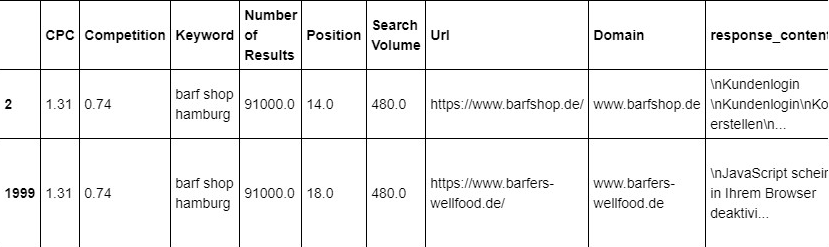

In [16]:
Image(filename="E:\Machine Learning for SEO\well.jpg")

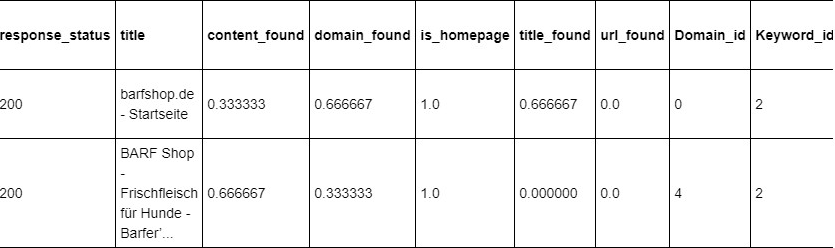

In [18]:
Image(filename="E:\Machine Learning for SEO\well-parttwo.jpg")

In [19]:
# get only the top 40 results
# rated_df_top40 = rated_df[rated_df["Position"]<40]

In [ ]:
# Delete all rows with no response_status (if any)
rated_df.dropna(subset=['response_status'], how='all', inplace=True)
print("{} rows for machine learning".format(len(rated_df.index)))

In [23]:
#result will be "4742 rows for machine learning" (after executing the code) 

In [ ]:
# Define Features (which rows should the ml algorithm should consider for learning)
features = ["Domain_id", 
            "content_found", 
            "domain_found",
            "title_found", 
            "url_found", 
            "Keyword_id", 
            "CPC", 
            "Number of Results",
            "Search Volume"]
# Define Target (What should be predicted)
target = "Position"

In [ ]:
# Split in train and test data
train = rated_df.sample(frac=0.8)
test = rated_df.loc[~rated_df.index.isin(train.index)]
print ("Train rows: {}".format(len(train.index)))
print ("Test rows: {}".format(len(test.index)))

In [22]:
#result is Train rows: 3794,Test rows: 948 (After executing the code)

In [ ]:
# Train Model with Data
from sklearn.preprocessing import StandardScaler  
from sklearn.model_selection import LeaveOneOut
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

sc = StandardScaler()

mlc = MLPClassifier(activation = 'relu', random_state=1,nesterovs_momentum=True)
loo = LeaveOneOut()
pipe = make_pipeline(sc, mlc)

# Train the Model and check wich of the Parameters works best
parameters = { "mlpclassifier__hidden_layer_sizes":[(300,),(500,)],  
              "mlpclassifier__solver" : ( "sgd", "lbfgs"), 
              "mlpclassifier__max_iter": [500, 1000, 2000], 
              "mlpclassifier__learning_rate_init":[0.001, 0.1]  }
MLPClassifierModel = GridSearchCV(pipe, parameters,n_jobs= -1,cv = 5)
MLPClassifierModel.fit(train[features], train[target])

# Save Model to file to used it later
file = open("k_t_o_MLPClassifierModel_10_comp.pkl", 'wb')
pickle.dump(MLPClassifierModel, file)
file.close()

In [ ]:
# Open Model from File (could be skipped if you've trained it just a second before ;) )
file = open("k_t_o_MLPClassifierModel_10_comp.pkl", 'rb')
MLPClassifierModel = pickle.load(file)
file.close()

In [ ]:
rated_df[rated_df["Domain"]==main_domain]

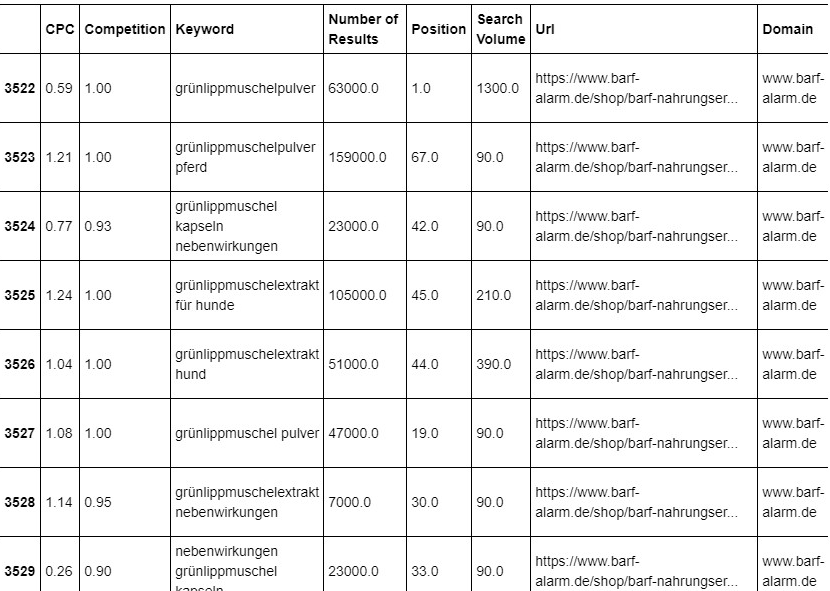

In [32]:
Image(filename="E:\Machine Learning for SEO\well-partfour.jpg")

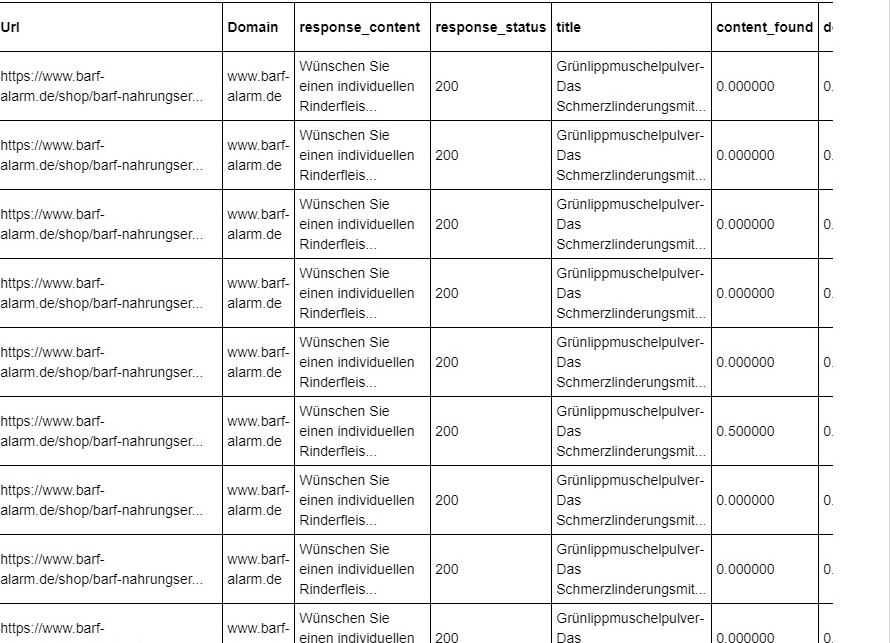

In [33]:
Image(filename="E:\Machine Learning for SEO\well-partfive.jpg")

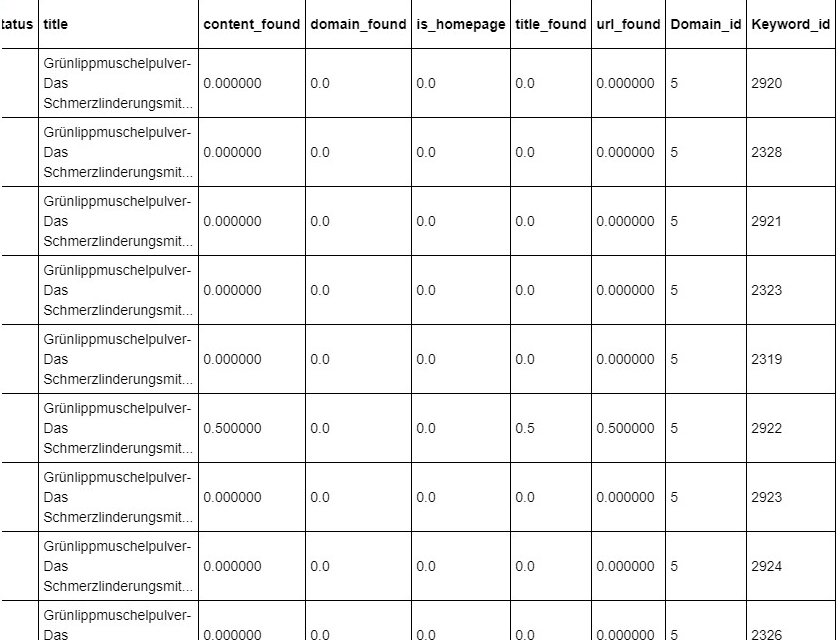

In [34]:
Image(filename="E:\Machine Learning for SEO\well-partsix.jpg")

In [35]:
# Above three tables are three parts of a same table to elaborate column names.
#This is a long list of 1084 rows × 18 columns which cannot be displayed here with executing actual code.

In [ ]:
# Get Data to query the Model
id = 3538 # just change ID to one of the row ids from above
data = [
    rated_df.ix[id]["Domain_id"],
    rated_df.ix[id]["content_found"],
    rated_df.ix[id]["domain_found"],
    rated_df.ix[id]["title_found"],
    rated_df.ix[id]["url_found"],
    rated_df.ix[id]["Keyword_id"],
    rated_df.ix[id]["CPC"],
    rated_df.ix[id]["Number of Results"],
    rated_df.ix[id]["Search Volume"],
]

In [ ]:
# What Data we query?
def print_data(data):
    print("Domain: {}".format(domains[int(data[0])]))
    print("Keyword: {}".format(keywords[int(data[5])]))
    print("Keyword in Content Found? {}".format(data[1]))
    print("Keyword in Title Found? {}".format(data[3]))
    print("Keyword in Domain Found? {}".format(data[2]))
    print("Keyword in URL Found? {}".format(data[4]))
    print("CPC: {}".format(data[6]))
    print("Number of Results: {}".format(data[7]))
    print("Search Volume: {}".format(data[8]))
print_data(data)

In [36]:
# When the code will be executed the result would be:
# Domain: www.barf-alarm.de
# Keyword: rohfleisch hund
# Keyword in Content Found? 0.5
# Keyword in Title Found? 0.0
# Keyword in Domain Found? 0.0
# Keyword in URL Found? 0.5
# CPC: 1.21
# Number of Results: 32000.0
# Search Volume: 90.0

In [ ]:
# Predict Position
df_to_predict = pd.DataFrame(data = [data], index=[0], columns=features)
res = MLPClassifierModel.predict(df_to_predict)
print("MLPClassifierModel predicted Position:  {}".format(int(res[0])))

In [37]:
# Result would be "MLPClassifierModel predicted Position:  13"

In [ ]:
# Modify Data for that Keyword
modified_data = data
data[1] = 1
data[3] = 1
print_data(modified_data)

In [38]:
# Result would be:
# Domain: www.barf-alarm.de
# Keyword: rohfleisch hund
# Keyword in Content Found? 1
# Keyword in Title Found? 1
# Keyword in Domain Found? 0.0
# Keyword in URL Found? 0.5
# CPC: 1.21
# Number of Results: 32000.0
# Search Volume: 90.0

In [ ]:
# Predict Position
df_to_predict = pd.DataFrame(data = [modified_data], index=[0], columns=features)
res = MLPClassifierModel.predict(df_to_predict)
print("MLPClassifierModel predicted Position:  {}".format(int(res[0])))

In [39]:
# Now we want to predict Positions for all Keywords if title & Description are optimized for one of the Domains

In [ ]:
# Get a list with all Keywords and if any with position and found Url
predict_df = pd.merge(keyword_df[keyword_df["Domain"]==main_domain][["Position", "Keyword", "Url"]],keyword_df_unique, on='Keyword', how='outer')

In [ ]:
predict_df.head()

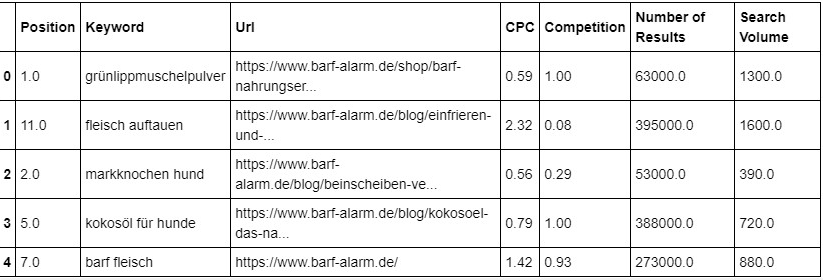

In [40]:
Image(filename="E:\Machine Learning for SEO\well-seven.jpg")

In [ ]:
domain_id = get_domain_id(main_domain)
# Predict Data for each row
def optimized_position(args):
    try: 
        keyword_id = get_keyword_id(args["Keyword"])
    except:
        return pd.Series({'optimized_position': None })
    data = [
        domain_id,
        1,
        0,
        1,
        0,
        keyword_id,
        args["CPC"],
        args["Number of Results"],
        args["Search Volume"]
    ]
    df_to_predict = pd.DataFrame(data = [data], index=[0], columns=features)
    res = MLPClassifierModel.predict(df_to_predict)
    return pd.Series({'optimized_position': int(res[0])})

final_df = predict_df.join(predict_df.apply(optimized_position, axis=1))

In [ ]:
new_result = final_df.sort_values('Search Volume', ascending=False)[final_df["optimized_position"]<10]

In [ ]:
# Show Keywords where the Model predicts a top 10 Position
new_result

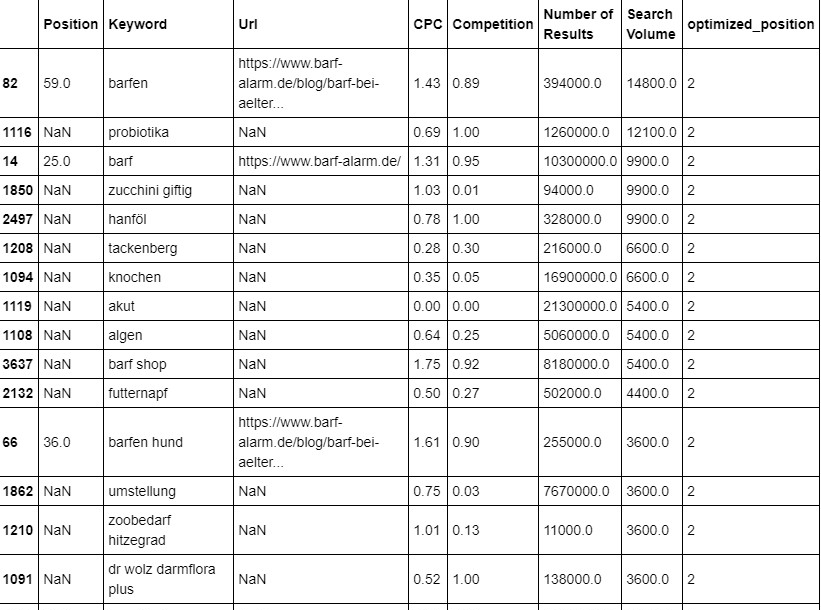

In [41]:
Image(filename="E:\Machine Learning for SEO\well-eight.jpg")

In [42]:
# This is a long list having more rows below. 1026 rows × 8 columns total.

In [ ]:
new_result.to_csv("result.csv")